# Options 4: Hedging Options

This notebook illustrates how a position in the underlying asset can be used to hedge an option (delta hedging).

## Load Packages and Extra Functions

In [1]:
using Printf, Distributions

include("jlFiles/printmat.jl")

printyellow (generic function with 1 method)

In [2]:
using Plots

#pyplot(size=(600,400))
gr(size=(480,320))
default(fmt = :svg)

# A First-Order Approximation of the Option Price Change

"Delta hedging" is based on the idea that we can approximate the change in the option price by 

$C_{t+h}-C_{t}\approx \Delta_t \left(  S_{t+h}-S_{t}\right)$,

where $\Delta_t$ is the derivative of the call option price wrt. the underlying asset price.

In the Black-Scholes model, the Delta of a call option is

$\Delta=\frac{\partial C}{\partial S}=e^{-\delta m}\Phi\left(  d_{1}\right),$ 

where $d_1$ is the usual term in Black-Scholes. 

Similarly, the Delta of a put option is 

$\frac{\partial P}{\partial S}=e^{-\delta m}[\Phi\left(  d_{1}\right)-1]$.

The file included in the next cell contains the functions `Φ()` and `OptionBlackSPs()` from the chapter on the Black-Scholes model. 

The subsequent cell defines a function for the $\Delta$ of the Black-Scholes model.

In [3]:
include("jlFiles/OptionsCalculations.jl")

OptionBlackSPs

In [4]:
"""
Calculate the Black-Scholes delta
"""
function OptionDelta(S,K,m,y,σ,δ=0,PutIt=false)
    d1 = ( log(S/K) + (y-δ+0.5*σ^2)*m ) / (σ*sqrt(m))
    d2 = d1 - σ*sqrt(m)
    if PutIt
        Δ = exp(-δ*m)*(Φ(d1)-1)
    else
        Δ = exp(-δ*m)*Φ(d1)
    end
    return Δ
end

OptionDelta

In [5]:
(S,K,m,y,σ) = (42,42,0.5,0.05,0.2)

Δ_c = OptionDelta(S,K,m,y,σ)               #call
Δ_p = OptionDelta(S,K,m,y,σ,0,true)        #put

printlnPs("Δ:")
printmat([Δ_c Δ_p (Δ_c-Δ_p)],colNames=["call","put","difference"],width=12)

        Δ:
        call         put  difference
       0.598      -0.402       1.000



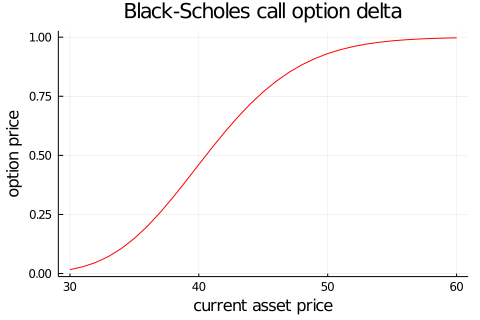

In [6]:
S_range     = 30:60          #different spot prices
Δ_c_S_range = OptionDelta.(S_range,K,m,y,σ)

p1 = plot( S_range,Δ_c_S_range,
           linecolor = :red,
           legend = false,
           title = "Black-Scholes call option delta",
           xlabel = "current asset price",
           ylabel = "option price" )
display(p1)

# Hedging an Option

The example below shows how a delta hedging works for a European call option when the price of the underlying changes (from 42 on day 0 to 43 on day 1). For simplicity, we assume that the Black-Scholes model is a good description of how the option price is set.

In [7]:
(S₀,S₁,K,m,y,σ) = (42,43,42,0.5,0.05,0.2)

C₀ = OptionBlackSPs(S₀,K,m,y,σ)   #option price at S₀
Δ₀ = OptionDelta(S₀,K,m,y,σ)      #Delta at S₀
M₀ = C₀ - Δ₀*S₀                    #on money market account

C₁ = OptionBlackSPs(S₁,K,m-1/252,y,σ)   #option price at S₁ (it's one day later) 
dC = C₁ - C₀                      #change of option value
dV = Δ₀*(S₁-S₀) - (C₁-C₀)           #change of hedge portfolio value

xy = [S₀,Δ₀,C₀,M₀,S₁,C₁,dC,dV]
printmat(xy,rowNames=["S₀","Δ₀","C₀","M₀","S₁","C₁","dC","dV"])

printblue("\nV changes much less in value than the option (abs(dV) < abs(dC)): 
the hedge helps")

S₀    42.000
Δ₀     0.598
C₀     2.893
M₀   -22.212
S₁    43.000
C₁     3.509
dC     0.616
dV    -0.018


V changes much less in value than the option (abs(dV) < abs(dC)): 
the hedge helps


## Hedging an Option Portfolio

We own 3 call options and have issued 2 put options with strike $K$ and want to know how many of the underlying asset that we need  in order to be hedged.

In [8]:
(S₀,K,m,y,σ) = (42,42,0.5,0.05,0.2)


Δ_call = OptionDelta.(S₀,K,m,y,σ)         #Delta of call option
Δ_put  = OptionDelta.(S₀,K,m,y,σ,0,true)  #Delta of put option
Δ = 3*Δ_call - 2*Δ_put

xy = [Δ_call,Δ_put,Δ]
printmat(xy,rowNames=["Δ of call","Δ of put","Δ of option portfolio"])

printlnPs("We need to buy $(round(Δ,digits=3)) units of the underlying")

Δ of call                 0.598
Δ of put                 -0.402
Δ of option portfolio     2.598

We need to buy 2.598 units of the underlying
